In [18]:

#~ importing librairies

import pandas as pd, numpy as np, requests, os, matplotlib.pyplot as plt, seaborn as sns

from pathlib import Path




In [19]:

#~ setting up directories

PROJECT_ROOT = Path.cwd().resolve().parents[0]

DATA_DIR = PROJECT_ROOT / 'data' 

RAW_DIR = DATA_DIR / 'Raw'

PROCESSED_DIR = DATA_DIR / 'Processed'

In [20]:

model_df = pd.read_parquet(PROCESSED_DIR/'model_df.parquet')

display(model_df.head())

,startstationname,starttime_hourly,total_demand,arrondissement,temperature,precipitation,wind_speed,latitude,longitude,hour,...,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,feels_like_temp,is_raining,lag_1h,lag_24h,rolling_3h,rolling_24h
0,10e avenue / Masson,2023-04-13 17:00:00,17,Rosemont - La Petite-Patrie,22.1,0.0,9.0,45.550306,-73.573353,17,...,-0.965926,-2.588190e-01,0.433884,-0.900969,15.8,0,8.0,2.0,9.333333,4.583333
1,10e avenue / Masson,2023-04-13 18:00:00,14,Rosemont - La Petite-Patrie,23.9,0.0,9.0,45.550306,-73.573353,18,...,-1.000000,-1.836970e-16,0.433884,-0.900969,17.6,0,17.0,1.0,11.666667,5.208333
2,10e avenue / Masson,2023-04-13 19:00:00,3,Rosemont - La Petite-Patrie,25.9,0.0,7.0,45.550306,-73.573353,19,...,-0.965926,2.588190e-01,0.433884,-0.900969,21.0,0,14.0,1.0,13.000000,5.750000
3,10e avenue / Masson,2023-04-13 20:00:00,10,Rosemont - La Petite-Patrie,26.7,0.0,6.0,45.550306,-73.573353,20,...,-0.866025,5.000000e-01,0.433884,-0.900969,22.5,0,3.0,3.0,11.333333,5.833333
4,10e avenue / Masson,2023-04-13 21:00:00,6,Rosemont - La Petite-Patrie,27.0,0.0,7.0,45.550306,-73.573353,21,...,-0.707107,7.071068e-01,0.433884,-0.900969,22.1,0,10.0,4.0,9.000000,6.125000


Define target + features


In [21]:

TARGET = 'total_demand'

FEATURES = [
    'temperature',
    'precipitation',
    'wind_speed',
    'latitude',
    'longitude',
    'hour',
    'day_of_week',
    'is_weekend',
    'month',
    'hour_sin',
    'hour_cos',
    'day_of_week_sin',
    'day_of_week_cos',
    'feels_like_temp',
    'is_raining',
    'lag_1h',
    'lag_24h',
    'rolling_3h',
    'rolling_24h'
] 

X = model_df[FEATURES]

y = model_df[TARGET]

Splitting the dataset for train / validation / test split based on Time (starttime_hourly)

Train: 70%  ; Validation: 15%  ; Test: 15%

In [22]:

model_df.sort_values('starttime_hourly', inplace=True)

n = len(model_df)

train_end = int(n*0.7)

val_end = int(n*0.85)

X_train = X.iloc[:train_end]
y_train = y.iloc[:train_end]

X_val = X.iloc[train_end:val_end]
y_val = y.iloc[train_end:val_end]

X_test = X.iloc[val_end:]
y_test = y.iloc[val_end:]


# Baseline Model - Naive

In [23]:

from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score


baseline = DummyRegressor(strategy="mean")
baseline.fit(X_train, y_train)

baseline_pred = baseline.predict(X_val)
print("Baseline MAE:", mean_absolute_error(y_val, baseline_pred))
print('Baseline RMSE:', root_mean_squared_error(y_val, baseline_pred))
print('Baseline R2:', r2_score(y_val, baseline_pred))


Baseline MAE: 3.217133030515379
Baseline RMSE: 4.598473571989976
Baseline R2: -0.00110004856051793


# Random Forest Model

In [24]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    min_samples_leaf=20,
    max_features='sqrt',
    random_state=42,
    n_jobs=2
)

rf.fit(X_train, y_train)


,n_estimators,200
,criterion,'squared_error'
,max_depth,15
,min_samples_split,2
,min_samples_leaf,20
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [25]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

def eval_model(y_true, y_pred, label):
    print(f"{label}")
    print("R²:", round(r2_score(y_true, y_pred), 3))
    print("MAE:", round(mean_absolute_error(y_true, y_pred), 2))
    print("RMSE:", round(np.sqrt(mean_squared_error(y_true, y_pred)), 2))
    print("-" * 30)




In [26]:
eval_model(y_train, rf.predict(X_train), "Train")
eval_model(y_val, rf.predict(X_val), "Validation")
eval_model(y_test, rf.predict(X_test), "Test")

Train
R²: 0.66
MAE: 1.87
RMSE: 2.89
------------------------------
Validation
R²: 0.565
MAE: 2.04
RMSE: 3.03
------------------------------
Test
R²: 0.645
MAE: 2.05
RMSE: 3.15
------------------------------


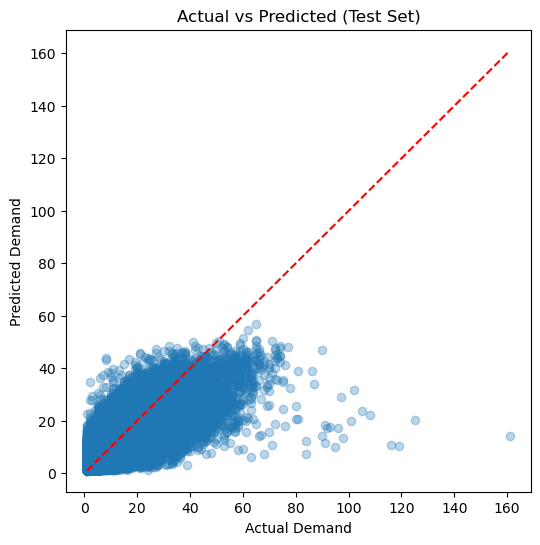

In [27]:

#~ scatterplot actual vs predicted
y_pred = rf.predict(X_test)

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         "--r")
plt.xlabel("Actual Demand")
plt.ylabel("Predicted Demand")
plt.title("Actual vs Predicted (Test Set)")
plt.show()


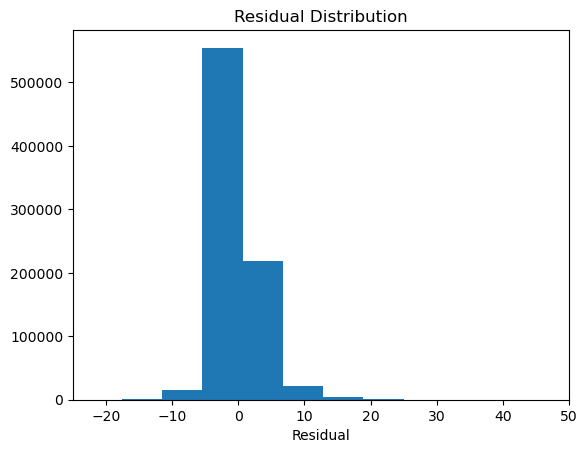

In [28]:

#~ residuals distribution plot

residuals = y_test - y_pred

plt.figure()
plt.hist(residuals, bins=30)
plt.title("Residual Distribution")
plt.xlabel("Residual")
plt.xlim(-25,50)
plt.show()


In [29]:
import shap

X_explain = X_test.copy()

#~Sample rows to explain
N_EXPLAIN = min(5000, len(X_explain))
X_explain_sample = X_explain.sample(n=N_EXPLAIN, random_state=42)

#~Background dataset for SHAP 
N_BG = min(500, len(X_train))
X_bg = X_train.sample(n=N_BG, random_state=42)


100%|===================| 4997/5000 [11:59<00:00]        

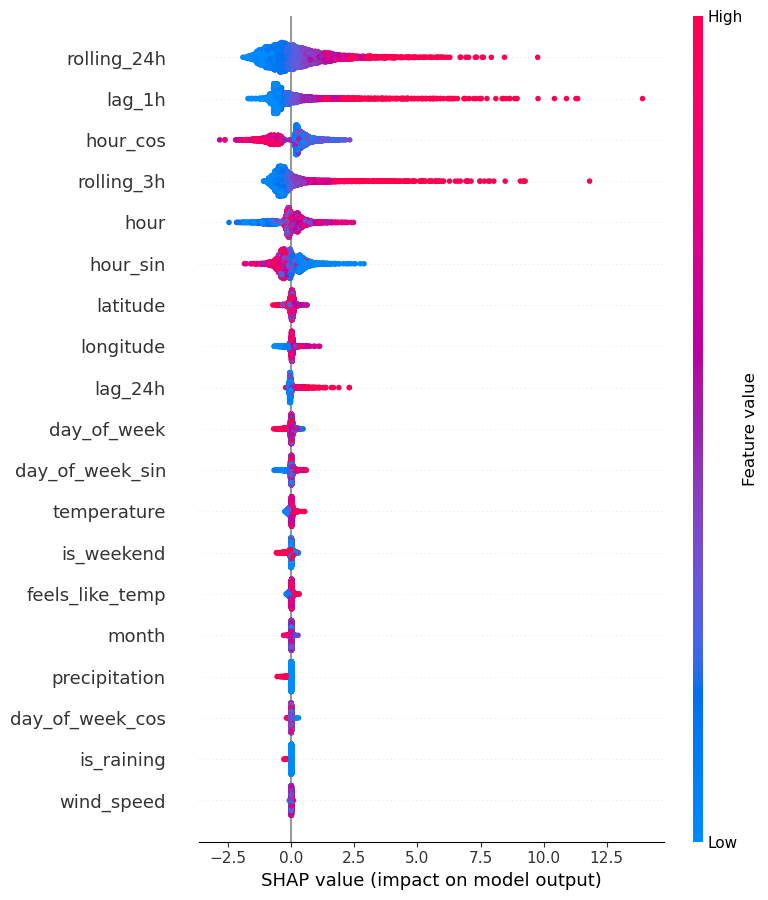

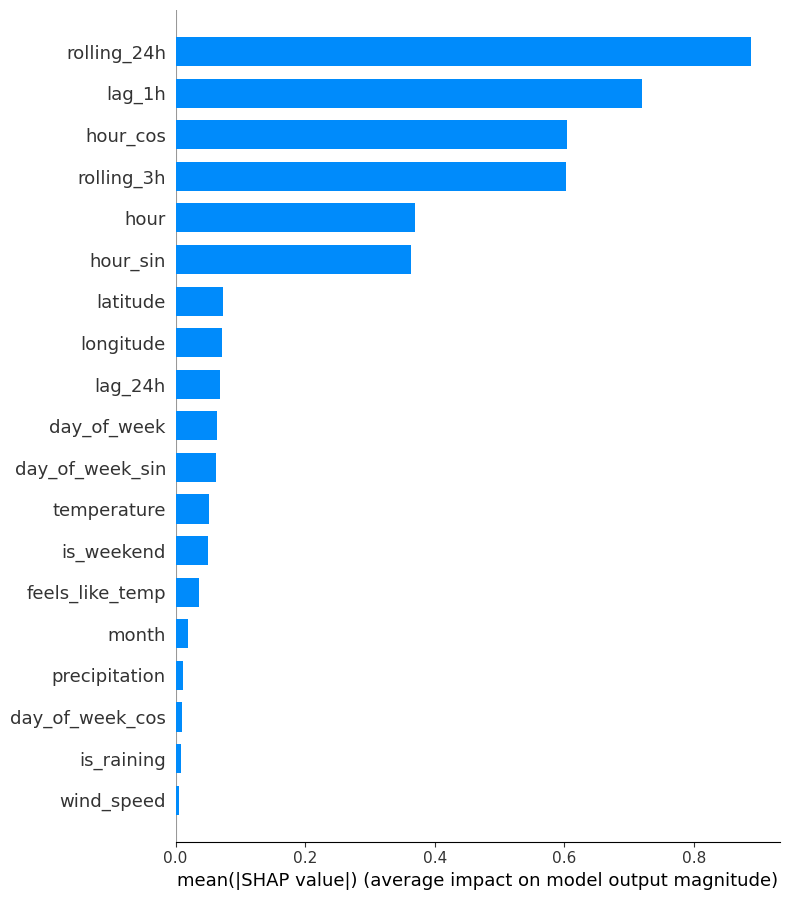

In [30]:


#~convert to plain numpy-friendly floats (removes pandas nullable dtypes)
X_bg_shap = X_bg.astype("float32").fillna(0.0)
X_explain_shap = X_explain_sample.astype("float32").fillna(0.0)

explainer = shap.TreeExplainer(rf, X_bg_shap)
shap_values = explainer.shap_values(X_explain_shap)

#~Global SHAP plots
shap.summary_plot(shap_values, X_explain_shap, show=False)
plt.tight_layout(); plt.show()

shap.summary_plot(shap_values, X_explain_shap, plot_type="bar", show=False)
plt.tight_layout(); plt.show()


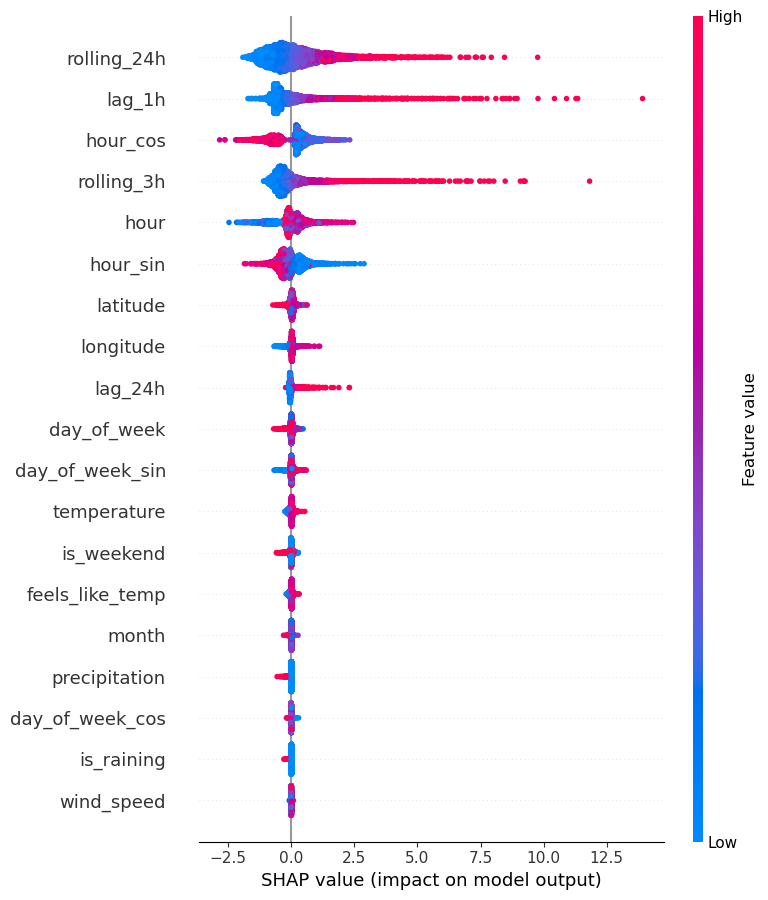

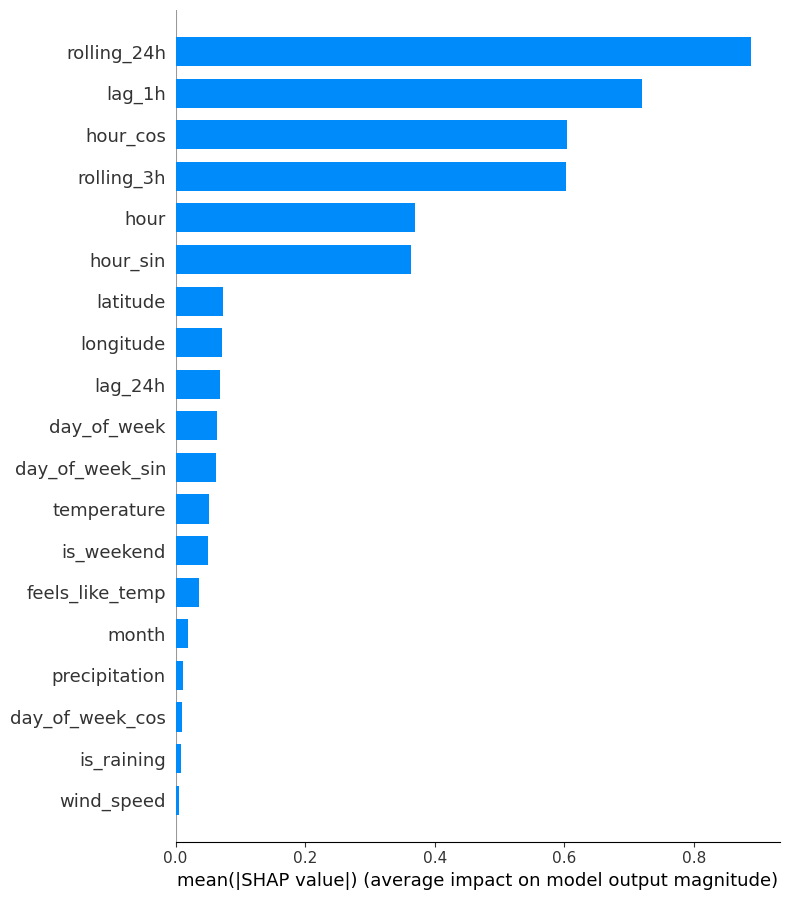

# Histogram Gradient Boosting Regressor Model

In [31]:
from sklearn.ensemble import HistGradientBoostingRegressor

hgb = HistGradientBoostingRegressor(
    max_depth=10,
    learning_rate=0.05,
    max_iter=400,
    random_state=42
)

hgb.fit(X_train, y_train)


,loss,'squared_error'
,quantile,None
,learning_rate,0.05
,max_iter,400
,max_leaf_nodes,31
,max_depth,10
,min_samples_leaf,20
,l2_regularization,0.0
,max_features,1.0
,max_bins,255
,categorical_features,'from_dtype'


In [32]:

#~ evaluate HGB model
eval_model(y_train, hgb.predict(X_train), "Train")
eval_model(y_val, hgb.predict(X_val), "Validation")
eval_model(y_test, hgb.predict(X_test), "Test")


Train
R²: 0.658
MAE: 1.89
RMSE: 2.9
------------------------------
Validation
R²: 0.57
MAE: 2.03
RMSE: 3.01
------------------------------
Test
R²: 0.648
MAE: 2.04
RMSE: 3.14
------------------------------


# Exporting Models as pkl files

In [33]:

#~ exporting the model as a pkl file

import joblib

joblib.dump(hgb, PROJECT_ROOT/'models'/'hgb_BIXI_DemandForecast_model_v1.pkl')

joblib.dump(rf, PROJECT_ROOT/'models'/'rf_BIXI_DemandForecast_model_v1.pkl')

['C:\\Users\\calvi\\Data Science\\cloudy_with_a_chance_of_bixi\\models\\rf_BIXI_DemandForecast_model_v1.pkl']